In [10]:
import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle
import pandas as pd
from matplotlib import pyplot as plt
from mne.minimum_norm import make_inverse_operator, apply_inverse
from matplotlib.patches import Patch


# Split data - Make events

In [2]:
# read one sample data
mne_filename = "mne_data/C10_32Ch_48Subjects_al_raw_eeg.fif"
raw = mne.io.read_raw_fif(mne_filename, verbose=False)

In [5]:
events = mne.make_fixed_length_events(raw, start=0, stop=20, duration=2., overlap=1.75, id = 1)

# forward solution

In [3]:
import os
import numpy as np

# Download fsaverage files
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in C:\Users\khanh.hanguyen\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\khanh.hanguyen\mne_data\MNE-fsaverage-data\fsaverage


In [12]:
# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name,
     ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    for ch_name in raw.ch_names)
raw.rename_channels(new_names)

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)  # needed for inverse modeling

# Check that the locations of EEG electrodes is correct with respect to MRI
# mne.viz.plot_alignment(
#     raw.info, src=src, eeg=['original', 'projected'], trans=trans,
#     show_axes=True, mri_fiducials=True, dig='fiducials')

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated


<Raw | C10_32Ch_48Subjects_al_raw_eeg.fif, 32 x 5120 (20.0 s), ~53 kB, data not loaded>

In [13]:
# annot = mne.Annotations(onset=[0.,5.,10.], duration=10., description=["seg_1", "seg_2", "seg_3"])
# list_raw = raw.crop_by_annotations(annot)
# list_raw

In [16]:
raw_list = [raw.copy().crop(i*5.,i*5.+10.,include_tmax=False) for i in range(2)]
raw_list.append(raw.copy().crop(10.))

In [13]:
fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                bem=bem, eeg=True, mindist=5.0)
print(fwd)

Source space          : C:\Users\khanh.hanguyen\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\khanh.hanguyen\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\khanh.hanguyen\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in he

# Making epochs

In [18]:
# event_id = dict(al=1)  # event trigger and conditions
# tmin = 0  # start of each epoch
# tmax = 2  # end of each epoch
# baseline = (0, 0)  # means from the first instant to t = 0
# reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

# epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
#                     picks="all", baseline=baseline)

epochs = mne.make_fixed_length_epochs(raw=raw, duration=2, overlap=0.75)

Not setting metadata
15 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


# Covariance

In [5]:
noise_cov = mne.compute_covariance(epochs, tmax=2)

# fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

NameError: name 'epochs' is not defined

# Var

In [7]:
noise_cov = mne.compute_covariance(epochs, tmax=2)

Loading data for 15 events and 512 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 9.8e-06 (2.2e-16 eps * 32 dim * 1.4e+09  max singular value)
    Estimated rank (eeg): 32
    EEG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 7680
[done]


C:\Users\khanh.hanguyen\AppData\Local\Temp\ipykernel_16016\2899780179.py:1: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  noise_cov = mne.compute_covariance(epochs, tmax=2)


In [9]:
from mne_connectivity import vector_auto_regression

conn = vector_auto_regression(
    data=epochs.get_data(), times=epochs.times, names=epochs.ch_names)

Loading data for 15 events and 512 original time points ...


100%|██████████| 15/15 [00:00<00:00, 212.94it/s]


Loading data for 15 events and 512 original time points ...
Loading data for 15 events and 512 original time points ...


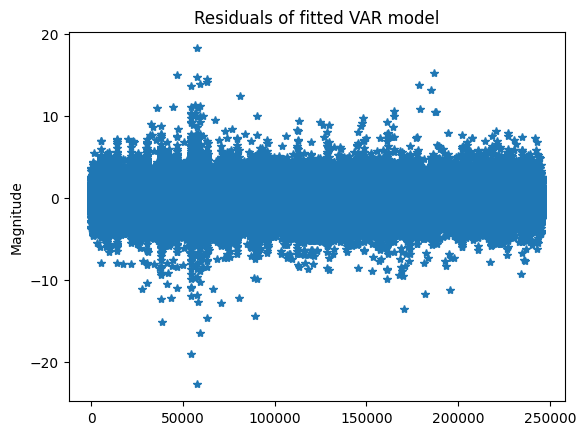

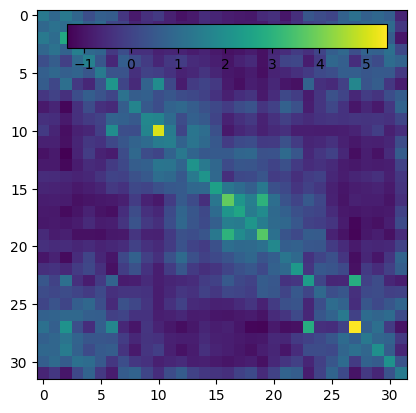

In [10]:
predicted_data = conn.predict(epochs.get_data())

# compute residuals
residuals = epochs.get_data() - predicted_data

# visualize the residuals
fig, ax = plt.subplots()
ax.plot(residuals.flatten(), '*')
ax.set(
    title='Residuals of fitted VAR model',
    ylabel='Magnitude'
)

# compute the covariance of the residuals
model_order = conn.attrs.get('model_order')
t = residuals.shape[0]
sampled_residuals = np.concatenate(
    np.split(residuals[:, :, model_order:], t, 0),
    axis=2
).squeeze(0)
rescov = np.cov(sampled_residuals)

# Next, we visualize the covariance of residuals.
# Here we will see that because we use ordinary
# least-squares as an estimation method, the residuals
# should come with low covariances.
fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
im = ax.imshow(rescov, cmap='viridis', aspect='equal', interpolation='none')
fig.colorbar(im, cax=cax, orientation='horizontal')

In [11]:
conn = vector_auto_regression(
    data=epochs.get_data(), times=epochs.times, names=epochs.ch_names,
    model='avg-epochs')

# this returns a connectivity structure over time
print(conn)

Loading data for 15 events and 512 original time points ...
<Connectivity | , nave : 15, nodes, n_estimated : 32, 1024, ~27 kB>


Loading data for 15 events and 512 original time points ...
Loading data for 15 events and 512 original time points ...


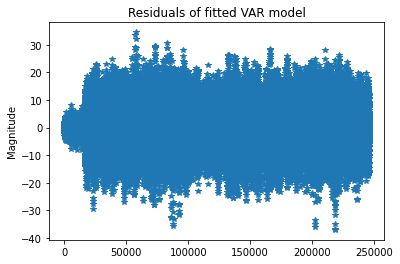

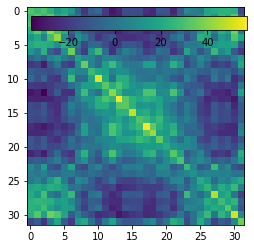

In [68]:
first_epoch = epochs.get_data()[0, ...]
predicted_data = conn.predict(first_epoch)

# compute residuals
residuals = epochs.get_data() - predicted_data

# visualize the residuals
fig, ax = plt.subplots()
ax.plot(residuals.flatten(), '*')
ax.set(
    title='Residuals of fitted VAR model',
    ylabel='Magnitude'
)

# compute the covariance of the residuals
model_order = conn.attrs.get('model_order')
t = residuals.shape[0]
sampled_residuals = np.concatenate(
    np.split(residuals[:, :, model_order:], t, 0),
    axis=2
).squeeze(0)
rescov = np.cov(sampled_residuals)

# Next, we visualize the covariance of residuals as before.
# Here we will see a similar trend with the covariances as
# with the covariances for time-varying VAR model.
fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
im = ax.imshow(rescov, cmap='viridis', aspect='equal', interpolation='none')
fig.colorbar(im, cax=cax, orientation='horizontal')

# Inverse operator

In [19]:
inverse_operator = make_inverse_operator(epochs.info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 26 channels.
    26 out of 32 channels remain after picking
Selected 26 channels
Creating the depth weighting matrix...
    26 EEG channels
    limit = 20485/20484 = 2.640160
    scale = 46206.1 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 0.011 (2.2e-16 eps * 26 dim * 1.9e+12  max singular value)
    Estimated rank (eeg): 24
    EEG: rank 24 computed from 26 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD 

In [46]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

In [15]:
# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                    subjects_dir=subjects_dir)
labels.pop(-1)
label_colors = [label.color for label in labels]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator['src']
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode='mean_flip', return_generator=True)

fmin = (0.5, 4., 8., 13., 30.)
fmax = (4., 8., 13., 30., 45.)
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['pli', 'wpli2_debiased', 'ciplv']
con = spectral_connectivity_epochs(
    label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c.get_data(output='dense')[:, :, 0]

Reading labels from parcellation...
   read 35 labels from C:\Users\khanh.hanguyen\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\khanh.hanguyen\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
Connectivity computation...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 24 (8 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 32 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 15
Extracting time courses for 68 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..1.996s for estimation (512 points)
    computing connectivity for the bands:
 

C:\Users\khanh.hanguyen\AppData\Local\Temp\ipykernel_9112\2148884993.py:17: RuntimeWarning: fmin=0.500 Hz corresponds to 1.000 < 5 cycles based on the epoch length 2.000 sec, need at least 10.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


    computing connectivity for epoch 2
Processing epoch : 3 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 3
Processing epoch : 4 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 4
Processing epoch : 5 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 5
Processing epoch : 6 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 6
Processing epoch : 7 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 7
Processing epoch : 8 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 8
Processing epoch : 9 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 9
Processing epoch : 10 / 15
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for 

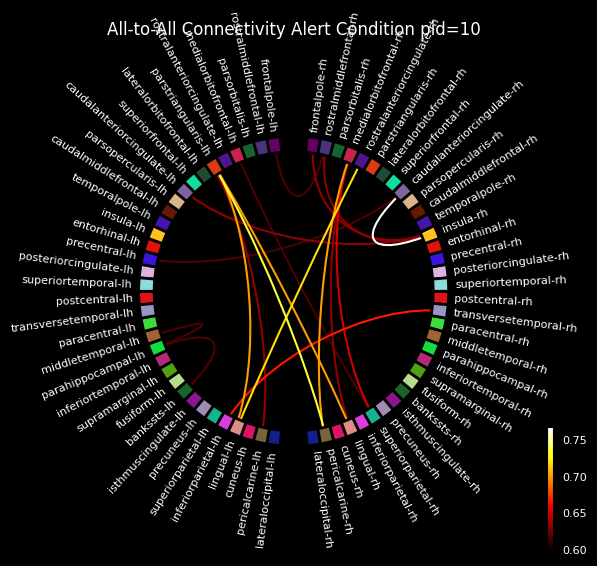

(<Figure size 800x800 with 2 Axes>,
 <PolarAxesSubplot: title={'center': 'All-to-All Connectivity Alert Condition pid=10'}>)

In [17]:
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
plot_connectivity_circle(con_res['pli'], label_names, n_lines=20,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity Alert Condition pid=10')

In [47]:
evoked = epochs.average()
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2,
                    method=method, pick_ori=None)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 15
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 24 (2 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 26 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  46.2% variance
    Combining the current components...
    dSPM...
[done]


In [48]:
type(stc.data)

numpy.ndarray

In [61]:
# average the source estimates over the time and assign the result to the last time point
avg = np.mean(stc.data, axis=1, keepdims=True)
stc.data[:,-1] = avg.reshape(-1)

array([0.5925593 , 0.96091765, 0.87887808, ..., 0.75974378, 0.96136778,
       1.12834114])

array([0.78738459, 0.8423456 , 0.88814866, ..., 0.70817625, 0.69657895,
       0.70386335])

(512,)

In [62]:
# %matplotlib qt4
brain = stc.plot( subjects_dir=subjects_dir, clim=dict(kind='value', lims=[3, 6, 9]),
                    surface='flat', hemi='both', size=(1000, 500),
                    smoothing_steps=5)
brain.scale_data_colormap(fmin=4, fmid=8, fmax=12, transparent=True)
brain.add_annotation('aparc', borders=2)
brain.show_view('lateral')

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



AttributeError: 'Brain' object has no attribute 'scale_data_colormap'

# Run the whole pipeline

### Grab files

In [11]:
mne_data = pd.read_csv("mne_data.csv")
mne_data

,pid,al,fa
0,1,mne_data/C1_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C1_32Ch_48Subjects_fa_raw_eeg.fif
1,2,mne_data/C2_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C2_32Ch_48Subjects_fa_raw_eeg.fif
2,3,mne_data/C3_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C3_32Ch_48Subjects_fa_raw_eeg.fif
3,4,mne_data/C4_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C4_32Ch_48Subjects_fa_raw_eeg.fif
4,5,mne_data/C5_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C5_32Ch_48Subjects_fa_raw_eeg.fif
5,6,mne_data/C6_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C6_32Ch_48Subjects_fa_raw_eeg.fif
6,7,mne_data/C7_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C7_32Ch_48Subjects_fa_raw_eeg.fif
7,8,mne_data/C8_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C8_32Ch_48Subjects_fa_raw_eeg.fif
8,9,mne_data/C9_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C9_32Ch_48Subjects_fa_raw_eeg.fif
9,10,mne_data/C10_32Ch_48Subjects_al_raw_eeg.fif,mne_data/C10_32Ch_48Subjects_fa_raw_eeg.fif


In [12]:
mne_files = mne_data[["al", "fa"]].values.reshape(-1)

In [19]:
# read one sample data
mne_filename = mne_files[0]
raw = mne.io.read_raw_fif(mne_filename, verbose=False)

# Download fsaverage files
fs_dir = mne.datasets.fetch_fsaverage(verbose=False)
subjects_dir = os.path.dirname(fs_dir)
# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage('standard_1020')

# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name,
    ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    for ch_name in raw.ch_names)
raw.rename_channels(new_names)
raw.set_montage(montage)
raw.set_eeg_reference(projection=True, verbose=False)  # needed for inverse modeling

fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                    bem=bem, eeg=True, mindist=5.0, verbose=False)


for mne_filename in mne_files:
    print(f"Running: {mne_filename}")
    # read file and make events
    p_id = mne_filename[10:12].replace("_","")
    if "_al_" in mne_filename: 
        condition = "al"
    elif "_fa_" in mne_filename:
        condition = "fa"
    raw = mne.io.read_raw_fif(mne_filename, verbose=False)

    # # split raw into 10 sec, overlap 5 sec
    # list_raw = [raw.copy().crop(i*5.,i*5.+10.,include_tmax=False) for i in range(2)]
    # list_raw.append(raw.copy().crop(10.))

    # for n_raw, raw in enumerate(list_raw):
    events = mne.make_fixed_length_events(raw, start=0., duration=2., overlap=1.75, id = 1)

    # Clean channel names to be able to use a standard 1005 montage
    new_names = dict(
        (ch_name,
        ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
        for ch_name in raw.ch_names)
    raw.rename_channels(new_names)
    raw.set_montage(montage)
    raw.set_eeg_reference(projection=True, verbose=False)  # needed for inverse modeling
    
    # make epochs
    event_id = dict(epoch=1)  # event trigger and conditions
    tmin = 0  # start of each epoch
    tmax = 2  # end of each epoch
    baseline = (0, 0)  # means from the first instant to t = 0
    reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                        picks="all", baseline=baseline, verbose=False)
    
    # covariance and inverse operator
    noise_cov = mne.compute_covariance(epochs, tmax=2, verbose=False)
    inverse_operator = make_inverse_operator(epochs.info, fwd, noise_cov,
                                        loose=0.2, depth=0.8, verbose=False)
    
    method = "dSPM"
    snr = 3.
    lambda2 = 1. / snr ** 2
    stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                                pick_ori="normal", return_generator=True, verbose=False)

    # save the stcs
    for n_stc, stc in enumerate(stcs):
        # save to file in the inverse_solution folder
        # check the folder exists
        if not os.path.exists(f"inverse_solution/{p_id}/{condition}"):
            os.makedirs(f"inverse_solution/{p_id}/{condition}")
        stc.save(f"inverse_solution/{p_id}/{condition}/{n_stc}.stc")

        
        # # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
        # labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
        #                                     subjects_dir=subjects_dir, verbose=False)
        # labels.pop(-1) # remove the unknown label
        # label_colors = [label.color for label in labels]

        # # Average the source estimates within each label using sign-flips to reduce
        # # signal cancellations, also here we return a generator
        # src = inverse_operator['src']
        # label_ts = mne.extract_label_time_course(
        #     stcs, labels, src, mode='mean_flip', return_generator=True, verbose= False)
        
        # fmin = (0.5, 4., 8., 13., 30.)
        # fmax = (4., 8., 13., 30., 45.)
        
        # sfreq = raw.info['sfreq']  # the sampling frequency
        # con_methods = ['pli', 'wpli2_debiased', 'ciplv']
        # con = spectral_connectivity_epochs(
        #     label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
        #     fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1, verbose=False)

        # # con is a 3D array, get the connectivity for the first (and only) freq. band
        # # for each method
        # output_dir_prefix = "output/split_10s_overlap_5s"
        # for method, c in zip(con_methods, con):
        #     con_values = c.get_data(output='dense')
        #     for i, f in enumerate(["delta", "theta", "alpha", "beta", "gamma"]):
        #         con_values_by_freq = con_values[:,:,i]
        #         np.save(f"{output_dir_prefix}/{p_id}_{condition}_{method}_{f}_{n_raw}.npy", con_values_by_freq)


Running: mne_data/C1_32Ch_48Subjects_al_raw_eeg.fif
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 31 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 32 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 73
Writing STC to disk...
[done]
Processing epoch : 2 / 73
Writing STC to disk...
[done]
Processing epoch : 3 / 73
Writing STC to disk...
[done]
Processing epoch : 4 / 73
Writing STC to disk...
[done]
Processing epoch : 5 / 73
Writing STC to disk...
[done]
Processing epoch : 6 / 73
Writing STC to disk...
[done]
Processing epoch : 7 / 73
Writing STC to disk...
[done]
Processing epoch : 8 / 73
Writing STC to disk...
[done]
Processing epoch : 9 / 73
Writing STC to disk...
[d

In [45]:
stc.data

array([[1.421073  , 1.041343  , 0.58852315, ..., 0.78738457, 0.78738433,
        0.78738433],
       [0.50848836, 0.16190471, 0.17264196, ..., 0.8423456 , 0.84234583,
        0.84234583],
       [0.2985898 , 0.40383193, 0.5227506 , ..., 0.88814867, 0.8881484 ,
        0.8881484 ],
       ...,
       [0.58142436, 0.24585226, 0.19511692, ..., 0.70817626, 0.708176  ,
        0.7081761 ],
       [0.81176883, 0.3649599 , 0.27590996, ..., 0.6965789 , 0.6965788 ,
        0.69657874],
       [1.0173558 , 0.51386166, 0.37437287, ..., 0.7038633 , 0.70386285,
        0.70386285]], dtype=float32)

# visualization

In [ ]:
import glob
import numpy as np


In [131]:
freq = ['alpha', 'beta', 'theta'
method = 'pli'
output_dir_prefix = "output/no_split"
# condition = "al"

In [132]:
labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                            subjects_dir=subjects_dir, verbose=False)
labels.pop(-1) # remove the unknown label

<Label | fsaverage, 'unknown-lh', lh : 2 vertices>

In [133]:

al_sum = np.zeros((len(labels), len(labels)))
# get all the files
files = glob.glob(f"{output_dir_prefix}/*al*{method}*{freq}*.npy")
# print(files)
for file in files:
    
    al_sum += np.load(file)

al_sum = al_sum / len(files)

In [134]:

fa_sum = np.zeros((len(labels), len(labels)))
# get all the files
files = glob.glob(f"{output_dir_prefix}/*fa*{method}*{freq}*.npy")
# print(files)
for file in files:
    
    fa_sum += np.load(file)

fa_sum = fa_sum / len(files)

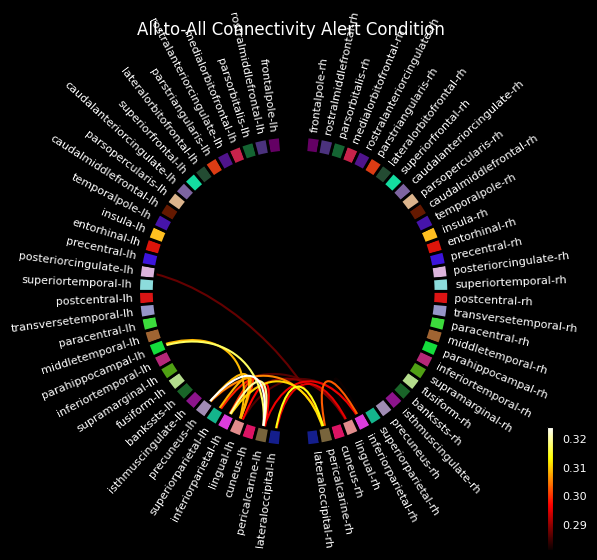

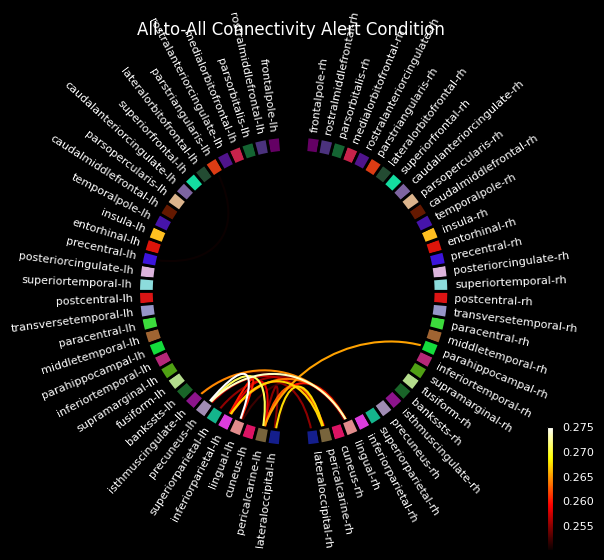

(<Figure size 800x800 with 2 Axes>,
 <PolarAxesSubplot: title={'center': 'All-to-All Connectivity Alert Condition '}>)

In [138]:
# First, we reorder the labels based on their location in the left hemi
label_colors = [label.color for label in labels]
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

plot_connectivity_circle(fa_sum, label_names, n_lines=20,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity Alert Condition ')

plot_connectivity_circle(al_sum, label_names, n_lines=20,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity Alert Condition ')

In [147]:
labels[1].pos[:, 1]

array([-0.0437955 , -0.04144555, -0.04009668, ..., -0.04181541,
       -0.0415423 , -0.04123544])

In [205]:
lobe_map = {"Frontal":{
                "frontalpole":"Frontal Pole",
                "medialorbitofrontal":"Medial Orbitofrontal",
                "lateralorbitofrontal":"Lateral Orbitofrontal",
                "paracentral":"Paracentral",
                "parsopercularis":"Pars Opercularis",
                "parsorbitalis":"Pars Orbitalis",
                "parstriangularis":"Pars Triangularis",
                "precentral": "Precentral",
                "rostralanteriorcingulate":"Rostral Anterior Cingulate",
                "rostralmiddlefrontal":"Rostral Middle Frontal",
                "superiorfrontal":"Superior Frontal",
                "caudalanteriorcingulate":"Caudal Anterior Cingulate Cortex",
                "caudalmiddlefrontal":"Caudal Middle Frontal Gyrus",
            },
            "Parietal":{
                "superiorparietal":"Superior Parietal",
                "inferiorparietal":"Inferior Parietal",
                "isthmuscingulate":"Isthmus Cingulate",
                "postcentral":"Postcentral Gyrus",
                "posteriorcingulate":"Posterior Cingulate Cortex",
                "precuneus":"Precuneus",
                "supramarginal":"Supramarginal Gyrus",
            },
            "Temporal":{
                "bankssts":"Banks of the Superior Temporal Sulcus",
                "entorhinal":"Entorhinal Cortex",
                "fusiform":"Fusiform Gyrus",
                "middletemporal":"Middle Temporal Gyrus",
                "parahippocampal":"Parahippocampal Gyrus",
                "superiortemporal": "Superior Temporal Gyrus",
                "temporalpole":"Temporal Pole",
                "transversetemporal":"Transverse Temporal Gyrus",
                "inferiortemporal":"Inferior Temporal Gyrus",
            },
            "Occipital":{
                "cuneus":"Cuneus",
                "lateraloccipital":"Lateral Occipital",
                "lingual":"Lingual Gyrus",
                "pericalcarine":"Pericalcarine",
            },
            "Insula":{
                "insula":"Insula"
            }
}
lobe_map_color = {"Frontal": (1,0,0),
                  "Insula": (0,1,0),
                "Temporal": (0,0,1),
                "Parietal": (1, 1,0), 
                 "Occipital": (0,1,1),
}

In [206]:
# First, we reorder the labels based on their location in the left hemi
label_colors = []
label_names = [label.name for label in labels]
for name in label_names:
    name = name.split("-")[0]
    for lobe in lobe_map:
        if name in list(lobe_map[lobe].keys()):
            label_colors.append(lobe_map_color[lobe])
            break

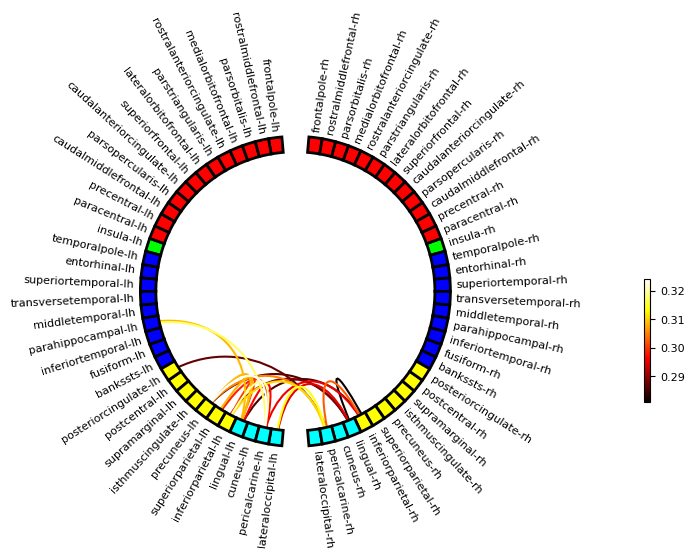

In [217]:
lh_labels = ['lateraloccipital-lh','pericalcarine-lh','cuneus-lh','lingual-lh',
            'inferiorparietal-lh','superiorparietal-lh','precuneus-lh','isthmuscingulate-lh','supramarginal-lh','postcentral-lh','posteriorcingulate-lh',
            'bankssts-lh','fusiform-lh','inferiortemporal-lh','parahippocampal-lh','middletemporal-lh','transversetemporal-lh','superiortemporal-lh','entorhinal-lh','temporalpole-lh',
            'insula-lh',
            'paracentral-lh','precentral-lh','caudalmiddlefrontal-lh','parsopercularis-lh','caudalanteriorcingulate-lh','superiorfrontal-lh','lateralorbitofrontal-lh','parstriangularis-lh','rostralanteriorcingulate-lh','medialorbitofrontal-lh','parsorbitalis-lh','rostralmiddlefrontal-lh','frontalpole-lh']
rh_labels = [label[:-2] + 'rh' for label in lh_labels]


# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

fig = plot_connectivity_circle(fa_sum, label_names, n_lines=20,
                         node_angles=node_angles, node_colors=label_colors,
                         facecolor='white', textcolor='black', colormap= 'hot', colorbar_pos=(0.8,0.4))

In [218]:
# add legend
# import mpatches from matplotlib

fig[0].legend(handles=[Patch(color=lobe_map_color[lobe], label=lobe) for lobe in lobe_map_color], loc='upper right', bbox_to_anchor=(0.95, 0.7),framealpha=0)

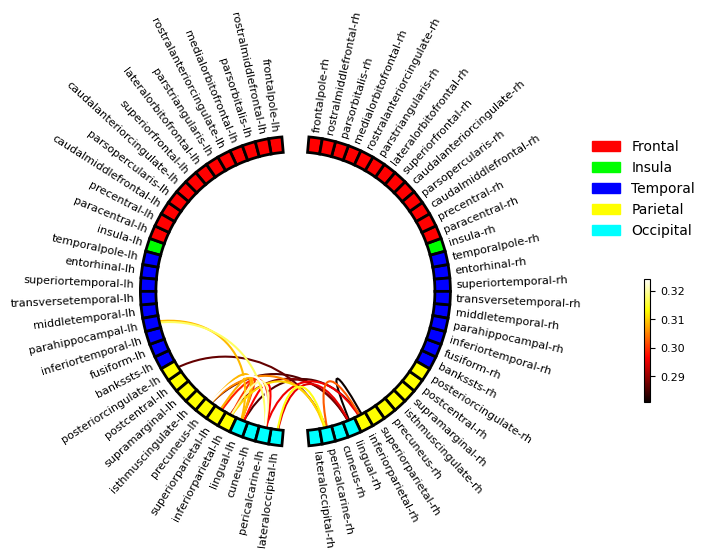

In [219]:
fig[0]